<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-baseline-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import sys
!{sys.executable} -m pip install contractions -q
!{sys.executable} -m pip install pyspark -q
!{sys.executable} -m pip install -U spacy -q
!{sys.executable} -m spacy download en_core_web_lg -q

     |████████████████████████████████| 106 kB 37.5 MB/s 
     |████████████████████████████████| 287 kB 88.6 MB/s 
2022-10-01 20:49:14.725593: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 10 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
url = 'https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv'
!wget {url}

--2022-10-01 17:38:49--  https://raw.githubusercontent.com/Tstrebe2/predicting-text-difficulty/main/assets/WikiLarge_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50868407 (49M) [text/plain]
Saving to: ‘WikiLarge_Train.csv’

WikiLarge_Train.csv 100%[===================>]  48.51M  --.-KB/s    in 0.1s    

2022-10-01 17:38:50 (348 MB/s) - ‘WikiLarge_Train.csv’ saved [50868407/50868407]



In [80]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType



spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

df = spark.read.csv('/content/WikiLarge_Train.csv', header=True)
df.createOrReplaceTempView('wiki')
df.printSchema()

root
 |-- original_text: string (nullable = true)
 |-- label: string (nullable = true)



In [81]:
spark.sql('SELECT * FROM wiki LIMIT 5;').show(5, 0)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|original_text                                                                                                                                                                                                                                           |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .             

In [99]:
import re
import contractions
from pyspark.sql.functions import regexp_replace



regex1, replace1 = r'-LRB-', '('
regex2, replace2 = r'-RRB-', ')'
regex3, replace3 = r"\'\' *", ''
regex4, replace4 = r", ; *", ''
regex5, replace5 = r"; , *", ''
regex6, replace6 = r", , *", ''
regex7, replace7 = r"; ; *", ''
regex8, replace8 = r"[(] [;,-]* [)] ", ''
regex9, replace9 = r"[(] +[)] *", ''
regex10, replace10 = r" km ", "kilometers"
regex11, replace11 = r"[0-9]+(km) ", "kilometers"
regex12, replace12 = r" mph "," miles per hour "
regex13, replace13 = r"° C ","degrees Celsius"
regex14, replace14 = r"° F ","degrees Farenheit"
regex15, replace15 = r"°","degrees"
regex16, replace16 = r" %"," percent"
regex17, replace17 = r" cm"," centimeters"
regex18, replace18 = r" kg "," kilograms "
regex18, replace18 = r" m "," kilograms "
regex19, replace19 = r" \'ve",r"\'ve"
regex20, replace20 = r" n\'t",r"n\'t"
regex21, replace21 = r"(?<=[ -])-",""

iterable = ((regex1, replace1), (regex2, replace2), (regex3, replace3),
            (regex4, replace4), (regex5, replace5), (regex6, replace6),
            (regex7, replace7), (regex8, replace8), (regex9, replace9),
            (regex10,replace10), (regex11,replace11),(regex12, replace12),
            (regex13, replace13),(regex14,replace14),(regex15,replace15),
            (regex16,replace16), (regex17,replace17),(regex18,replace18),
            (regex19,replace19),(regex20,replace20),(regex21,replace21))


# def CleanText(col):
#   for regex, replace in iterable:
#     x = regexp_replace(col, regex, replace)
#     x = contractions.fix(x)
#   return x


# clean_text_udf_string = udf(lambda x: CleanText(x),StringType())              
# spark.udf.register('clean_text_udf_string',CleanText)



for regex, replace in iterable:
  query = f"SELECT \
    regexp_replace(original_text, '{regex}', '{replace}') as original_text, \
    label FROM wiki;"

# query = """
#           SELECT clean_text_udf_string(original_text) as original_text,
#           label FROM wiki"""


df = spark.sql(query)
df.createOrReplaceTempView('wiki')

query = r"SELECT * FROM wiki WHERE LENGTH(original_text) > 20;"
df = spark.sql(query)
df.createOrReplaceTempView('wiki')

df.show(5, 0)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|original_text                                                                                                                                                                                                                                         |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .                   

In [100]:
df = df.toPandas()

In [101]:
RANDOM_STATE = 65

In [102]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50, stop_words='english', ngram_range=(1, 3))
X_vectorized = vectorizer.fit_transform(df['original_text'])
y = df['label'].astype(np.int64)

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, 
                                                    test_size=.1, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(356343, 15013) (39594, 15013) (356343,) (39594,)


In [96]:
# Classes are still adequately balanced
y_train.value_counts()

1    184830
0    171624
Name: label, dtype: int64

In [104]:
from sklearn.linear_model import LogisticRegression
# Modifying sklearn Logistic Regression model
# to incorporate l1 penalty to create sparse features
clf = LogisticRegression(penalty='l1', 
                           solver='liblinear', 
                           C=.5, 
                           random_state=RANDOM_STATE).fit(X_train, y_train)

Accuracy:  0.6759357478405819
ROC AUC:  0.7465547057775648
F1:  0.6859995595037075
Precision:  0.6894584091691672
Recall:  0.6825752410636018


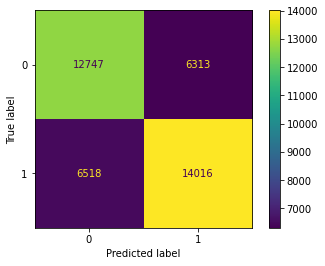

In [105]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_hat = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, y_prob)
# This is without threshold tuning
# We could tune the threshold to achieve greater classification accuracy
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)

print('Accuracy: ', accuracy)
print('ROC AUC: ', roc_auc)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

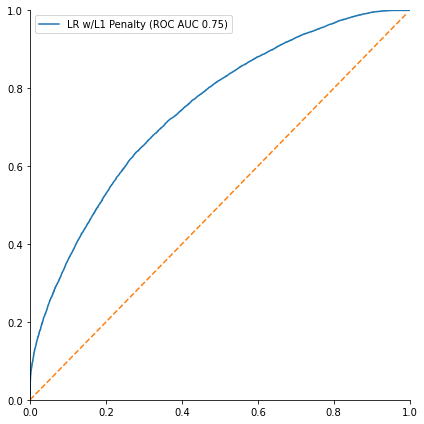

In [15]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, y_prob)
noskill = np.arange(0, 1, 0.01)

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

ax.plot(fpr, tpr, label=f'LR w/L1 Penalty (ROC AUC {roc_auc:.2f})')
ax.plot(noskill, noskill, linestyle='dashed')
ax.legend()
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.show()

In [ ]:

coef_df = (pd.DataFrame({'feature':vectorizer.get_feature_names_out(), 
              'coef':clf.coef_[0],
              'abs_coef':np.abs(clf.coef_)[0]})
.sort_values('abs_coef', ascending=False))

print('Total Features', X_train.shape[1])
print('N Coefficients GT zero:', coef_df[coef_df.abs_coef > 0].shape[0])
print('Ratio of Coefficients GT zero:', coef_df[coef_df.abs_coef > 0].shape[0]/X_train.shape[1])

Total Features 14060
N Coefficients GT zero: 6370
Ratio of Coefficients GT zero: 0.45305832147937414


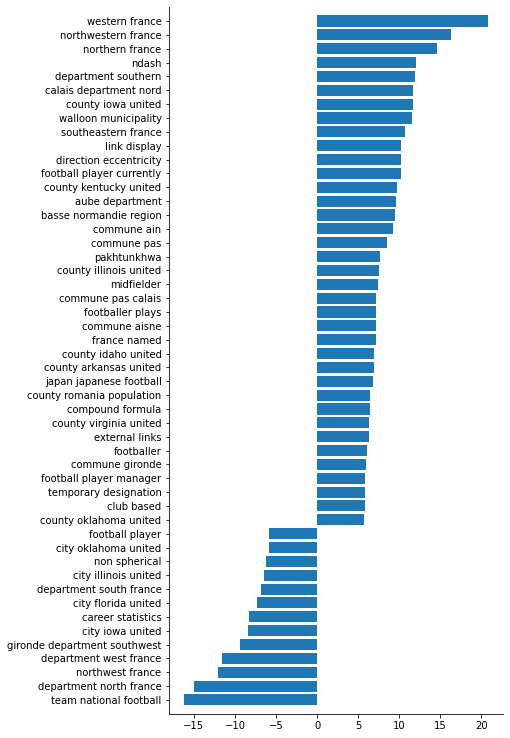

In [ ]:
def plot_feature_importances(coef_df, n_features=50):
  plot_df = coef_df.head(n_features).sort_values('coef')

  x = plot_df['coef']
  y = plot_df['feature']

  plt.figure(figsize=(6, 13))
  plt.barh(y, x)

  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)
  plt.ylim((-1, max(range(len(y)))+1))

  plt.show()

plot_feature_importances(coef_df)


In [106]:
# NaiveBayes Classifier Baseline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

In [107]:
mnb = MultinomialNB().fit(X_train,y_train)

In [108]:
# Quick check of accuracy on training data
accuracy = mnb.score(X_train, y_train)
print(accuracy)

0.6659987708471894


In [109]:
y_predict = mnb.predict(X_test)
accuracy = mnb.score(X_test, y_test)
f1 = f1_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
y_prob = mnb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)


print('Accuracy: ', accuracy)
print('ROC AUC: ', roc_auc)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

Accuracy:  0.6355255846845481
ROC AUC:  0.7048730493412456
F1:  0.6764132116510079
Precision:  0.6268129493413124
Recall:  0.7345378396805299


In [112]:
cnt_vectorizer = CountVectorizer(min_df=50, stop_words='english', ngram_range=(1, 3))
X_train_vec = cnt_vectorizer.fit_transform(df['original_text'])